# **CHURN ANALYSIS PROJECT**

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
warnings.filterwarnings('ignore')

## **IMPORTING CSV FILES**

### CHURN SUBS TABLE

In [ ]:
churn1_subs = pd.read_csv('/content/Churn_Subs_Table_Cohort.csv')
churn1_subs.head()

,Original Start Date,App Apple ID,Country Code,Package ID,Intro Duration,newSubs,Engagement,Total Churn,Cancel from Introductory
0,2019-10-31,1439290223,KZ,1447548278,3 Days,0,0,0,0
1,2020-01-01,1439290223,KZ,1447548278,3 Days,0,1,0,1
2,2019-12-28,1435773823,KZ,1446241754,3 Days,1,2,1,1
3,2019-10-30,1435773823,KZ,1446242014,3 Days,0,0,0,0
4,2019-10-31,1435773823,KZ,1446242014,3 Days,0,0,1,0


#### EXTRACTING INTRO DURATIONS AS DAYS IN NUMERIC DATATYPE

We get all unique values from 'Intro Duration' column and define day values respectively with creating condition and value table


In [ ]:
period_list = churn1_subs.drop_duplicates(['Intro Duration'])

In [ ]:
conditions = [(churn1_subs['Intro Duration'] == '3 Days'),
              (churn1_subs['Intro Duration'] == '1 Month'),
              (churn1_subs['Intro Duration'] == '7 Days'),
              ((churn1_subs['Intro Duration'] ==  'Non Duration') | (churn1_subs['Intro Duration'] == 'Non Duration - Lifetime') | (churn1_subs['Intro Duration'] == 'Non Duration - Consumable'))]

values = [3, 30, 7, 0]

churn1_subs['Intro'] = np.select(conditions, values)

churn1_subs.head()


,Original Start Date,App Apple ID,Country Code,Package ID,Intro Duration,newSubs,Engagement,Total Churn,Cancel from Introductory,Intro
0,2019-10-31,1439290223,KZ,1447548278,3 Days,0,0,0,0,3
1,2020-01-01,1439290223,KZ,1447548278,3 Days,0,1,0,1,3
2,2019-12-28,1435773823,KZ,1446241754,3 Days,1,2,1,1,3
3,2019-10-30,1435773823,KZ,1446242014,3 Days,0,0,0,0,3
4,2019-10-31,1435773823,KZ,1446242014,3 Days,0,0,1,0,3


In [ ]:
churn1_subs['Original Start Date With Intro'] = pd.to_datetime(churn1_subs['Original Start Date']) + pd.to_timedelta(churn1_subs['Intro'], 'D')


### KEY SET

In [ ]:
key_set = pd.read_csv('/content/Key Dataset.csv')
key_set

,Original Start Date,App Name,App Apple ID,Country,Subscription Name,Subscription Apple ID,Standard Subscription Duration,Intro Type,Subscription Offer Duration,Subscription Offer Type,Customer Price,Customer Currency,Developer Proceeds,Proceeds Currency,trialPrice,trialCurrency,trialProceed,trialProceedCurrency
0,2021-10-16,Call Recorder - Save & Listen,1.435774e+09,AR,Call Recorder Month Trial V2,1.446242e+09,1 Month,S,Non Duration,NaN,12.99,USD,9.10,USD,0.0,NaN,0.0,NaN
1,2021-10-15,Call Recorder - Save & Listen,1.435774e+09,AU,Call Recorder Month,1.435776e+09,1 Month,S,Non Duration,NaN,32.99,AUD,20.99,AUD,0.0,NaN,0.0,NaN
2,2021-10-15,Interview & Meeting Recorder,1.505287e+09,AU,Monthly one person v2,1.535635e+09,1 Month,S,Non Duration,NaN,48.99,AUD,31.18,AUD,0.0,NaN,0.0,NaN
3,2021-10-17,Scanner Unlimited: Scan & Sign,1.439290e+09,AU,Scanner Pro Year Trial,1.439370e+09,1 Year,S,Non Duration,NaN,129.99,AUD,82.72,AUD,0.0,NaN,0.0,NaN
4,2021-10-17,Fax - Scan PDF & Send Document,1.450602e+09,AU,Fax Month v2,1.548625e+09,1 Month,S,Non Duration,NaN,42.99,AUD,27.36,AUD,0.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50794,2022-01-15,"File Manager: Music, PDF, Text",1.575519e+09,US,Yearly Pro Subscription,1.576113e+09,1 Year,T,3 Days,Free Trial,0.00,USD,0.00,USD,0.0,NaN,0.0,NaN
50795,2022-01-15,App Vault: Hide Photos & Files,1.589920e+09,US,Yearly,1.591423e+09,1 Year,T,3 Days,Free Trial,0.00,USD,0.00,USD,0.0,NaN,0.0,NaN
50796,2022-01-15,Teleprompter Text & Word Timer,1.590820e+09,US,Yearly,1.591413e+09,1 Year,T,3 Days,Free Trial,0.00,USD,0.00,USD,0.0,NaN,0.0,NaN
50797,2022-01-15,"File Manager: Music, PDF, Text",1.575519e+09,US,Lifetime Subscription,1.576113e+09,Lifetime Duration,LT,Non Duration - Lifetime,NaN,39.99,USD,28.00,NaN,0.0,NaN,0.0,NaN


WE create a new attribute for calculating the aggregate values in 'Last N Days'

In [ ]:
churn1_subs['LastNDays'] = -(pd.to_datetime(churn1_subs['Original Start Date']) -
                             datetime(year=2022, month=1, day=16)).dt.days

We create a 'App Name' list for dimensioning our Churn Datasets.

In [ ]:
join = key_set[['App Apple ID', 'App Name']]
namelist = join.drop_duplicates(['App Apple ID','App Name'])
namelist

,App Apple ID,App Name
0,1.435774e+09,Call Recorder - Save & Listen
2,1.505287e+09,Interview & Meeting Recorder
3,1.439290e+09,Scanner Unlimited: Scan & Sign
4,1.450602e+09,Fax - Scan PDF & Send Document
13,1.538412e+09,Call Blocker: Scam Spam Lookup
18,1.481698e+09,Storico: Instagram Story Maker
29,1.575519e+09,"File Manager: Music, PDF, Text"
178,1.446726e+09,Card Scanner to Contacts + OCR
291,1.500566e+09,Secret Net VPN - Proxy Browser
406,1.529230e+09,Earni: Earn Money & Video Call


We filter our dimension data before join. We just take the target apps. 

In [ ]:
namelist = namelist[(namelist['App Name'] == 'Call Recorder - Save & Listen') |
                     (namelist['App Name'] == 'Interview & Meeting Recorder')   |
                     (namelist['App Name'] == 'Scanner Unlimited: Scan & Sign') |
                     (namelist['App Name'] == 'Fax - Scan PDF & Send Document') ]
namelist

,App Apple ID,App Name
0,1.435774e+09,Call Recorder - Save & Listen
2,1.505287e+09,Interview & Meeting Recorder
3,1.439290e+09,Scanner Unlimited: Scan & Sign
4,1.450602e+09,Fax - Scan PDF & Send Document


We merge namelist dataframe into our subs table

In [ ]:
churn1_subs1 = pd.merge(churn1_subs, namelist, on='App Apple ID', how="left")
churn1_subs1.head()


,Original Start Date,App Apple ID,Country Code,Package ID,Intro Duration,newSubs,Engagement,Total Churn,Cancel from Introductory,Intro,Original Start Date With Intro,LastNDays,App Name
0,2019-10-31,1439290223,KZ,1447548278,3 Days,0,0,0,0,3,2019-11-03,808,Scanner Unlimited: Scan & Sign
1,2020-01-01,1439290223,KZ,1447548278,3 Days,0,1,0,1,3,2020-01-04,746,Scanner Unlimited: Scan & Sign
2,2019-12-28,1435773823,KZ,1446241754,3 Days,1,2,1,1,3,2019-12-31,750,Call Recorder - Save & Listen
3,2019-10-30,1435773823,KZ,1446242014,3 Days,0,0,0,0,3,2019-11-02,809,Call Recorder - Save & Listen
4,2019-10-31,1435773823,KZ,1446242014,3 Days,0,0,1,0,3,2019-11-03,808,Call Recorder - Save & Listen


### **CHURN COHORT 2**

In [ ]:
churn2 = pd.read_csv('/content/Churn2_Cohort.csv')
churn2['Original Start Date'] = pd.to_datetime(churn2['Original Start Date'])

## TOP 10 MARKETS FOR RECORDERS

We create a list for our target countries for Recorder Apps. We just take top 10 countries.

In [ ]:
recorder_churn = churn1_subs1[(churn1_subs1['App Name']=='Call Recorder - Save & Listen') |
                              (churn1_subs1['App Name']=='Interview & Meeting Recorder')]
recorder_churn_sum = recorder_churn.groupby('Country Code')['newSubs'].sum()                              
recorder_churn_sum = recorder_churn_sum.sort_values(ascending = False)
recorder_churn_sum = recorder_churn_sum.iloc[np.r_[0:10]]
recorder_churn_sum

Country Code
US    21705
JP    19598
IN     5551
IL     5363
CA     4363
TR     4053
SA     2940
GB     2604
KR     2471
AU     2465
Name: newSubs, dtype: int64

In [ ]:
recorder_countries = recorder_churn_sum.index
recorder_countries

Index(['US', 'JP', 'IN', 'IL', 'CA', 'TR', 'SA', 'GB', 'KR', 'AU'], dtype='object', name='Country Code')

## TOP 10 MARKETS FOR SCANNER AND FAX

We made another country list for scanner apps.

In [ ]:
scanner_churn = churn1_subs1[(churn1_subs1['App Name']=='Scanner Unlimited: Scan & Sign') |
                              (churn1_subs1['App Name']=='Fax - Scan PDF & Send Document')]
scanner_churn_sum = scanner_churn.groupby('Country Code')['newSubs'].sum()                              
scanner_churn_sum = scanner_churn_sum.sort_values(ascending = False)
scanner_churn_sum = scanner_churn_sum.iloc[np.r_[0:5]]
scanner_churn_sum

Country Code
US    5983
CA    1266
IL     431
GB     403
SA     390
Name: newSubs, dtype: int64

In [ ]:
scanner_countries = scanner_churn_sum.index
scanner_countries

Index(['US', 'CA', 'IL', 'GB', 'SA'], dtype='object', name='Country Code')

## CHURN RATES FOR RECORDERS

We create a country mask for filtering only recorder top countries. And we apply the filter on churn subs table.

In [ ]:
recorder_mask = churn1_subs1['Country Code'].isin(recorder_countries)
recorder_churn2 = recorder_churn[recorder_mask]
recorder_churn2['Period'] = 0

In [ ]:
churn2.head()

,Original Start Date,AppID,Country Code,Package ID,Type,Period,Value
0,2021-08-04,1435773823,AR,1435787587,C,0,1
1,2021-08-04,1505286803,AR,1535633619,C,0,1
2,2021-08-04,1435773823,AR,1435787587,C,1,1
3,2021-08-05,1435773823,AR,1435787587,C,0,2
4,2021-08-04,1435773823,AU,1435787587,C,0,2


We create a measure for recorder subs table for aggregations. That measure fractures our data into last 15,30,45,60,180,900 days.

In [ ]:
days_recorder = pd.cut(recorder_churn2['LastNDays'], [0, 15, 30, 45, 60, 90, 180,900])


#### CREATING A PIVOT TABLE FOR OUR RECORDER CHURNS

In [ ]:
grouped_recorder = recorder_churn2.groupby(['App Name', 'Country Code', days_recorder])

recorder1 = grouped_recorder['Total Churn'].sum()

In [ ]:
recorder2 = grouped_recorder['newSubs'].sum()

recorder_final = pd.concat([recorder1, recorder2], axis=1)

recorder_final = recorder_final.fillna(0)

recorder_final

Total Churn  newSubs
App Name                      Country Code LastNDays                       
Call Recorder - Save & Listen AU           (0, 15]             1.0     21.0
                                           (15, 30]           13.0     24.0
                                           (30, 45]           28.0     38.0
                                           (45, 60]           28.0     44.0
                                           (60, 90]           62.0     88.0
...                                                            ...      ...
Interview & Meeting Recorder  US           (30, 45]           80.0    203.0
                                           (45, 60]           40.0    101.0
                                           (60, 90]           44.0     93.0
                                           (90, 180]         228.0    572.0
                                           (180, 900]       3613.0   4936.0

[140 rows x 2 columns]

We created our pivot table for Last N Days. We should aggregate our data again and find cumulative sums to get churn rates for last n days. So we need to reset our multi index to group the data again.

In [ ]:
recorder_final = recorder_final.reset_index()
recorder_final['Churn Cumsum'] = recorder_final.groupby(['App Name', 'Country Code'])['Total Churn'].cumsum()
recorder_final['New Cumsum'] = recorder_final.groupby(['App Name', 'Country Code'])['newSubs'].cumsum()
recorder_final['LastNDays'] = recorder_final['LastNDays'].astype(str)
recorder_final.head()

,App Name,Country Code,LastNDays,Total Churn,newSubs,Churn Cumsum,New Cumsum
0,Call Recorder - Save & Listen,AU,"(0, 15]",1.0,21.0,1.0,21.0
1,Call Recorder - Save & Listen,AU,"(15, 30]",13.0,24.0,14.0,45.0
2,Call Recorder - Save & Listen,AU,"(30, 45]",28.0,38.0,42.0,83.0
3,Call Recorder - Save & Listen,AU,"(45, 60]",28.0,44.0,70.0,127.0
4,Call Recorder - Save & Listen,AU,"(60, 90]",62.0,88.0,132.0,215.0


We transform 'LastNDays' from interval type to numeric.

In [ ]:
conditions1 = [(recorder_final['LastNDays'] == '(0, 15]'),
              (recorder_final['LastNDays'] == '(15, 30]'),
              (recorder_final['LastNDays'] == '(30, 45]'),
              (recorder_final['LastNDays'] ==  '(45, 60]'),
              (recorder_final['LastNDays'] == '(60, 90]'),
              (recorder_final['LastNDays'] == '(90, 180]')]

values1 = [15, 30, 45 , 60 , 90, 180 ]

recorder_final['LastN1Days'] = np.select(conditions1, values1)

recorder_final['Churn Rate'] = recorder_final['Churn Cumsum'] / recorder_final['New Cumsum']

recorder_final = recorder_final[recorder_final['LastN1Days'] != 0]

recorder_pivot = recorder_final.groupby(['App Name', 'Country Code', 'LastN1Days'])['Churn Rate'].sum()

### CHURN RATES/ LAST N DAYS FOR RECORDER APPS VISUAL

**We can say that Interview & Meeting Recorder App has an interesting line. That pattern in South Korea may be a problem for company.**

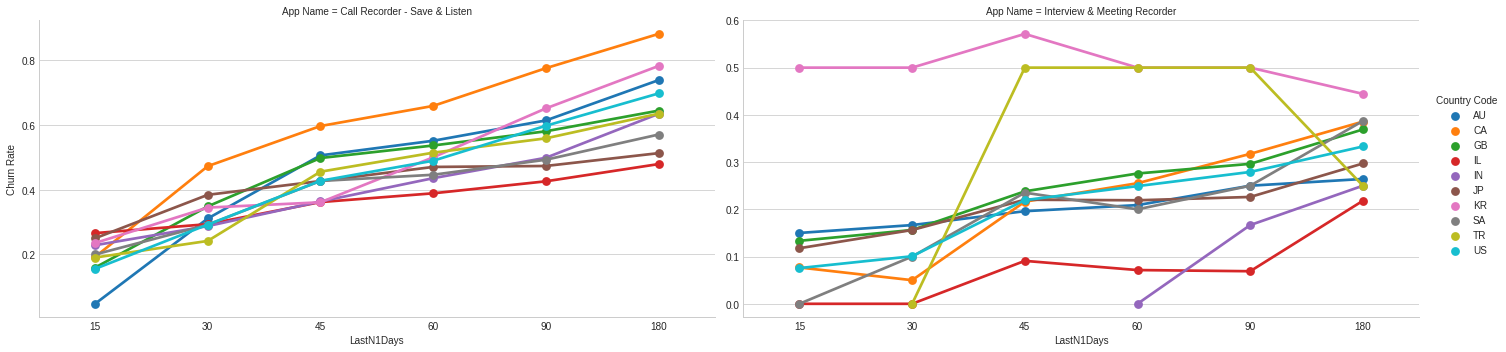

In [ ]:
sns.factorplot(x='LastN1Days', y='Churn Rate', hue='Country Code', 
               col='App Name', data=recorder_final, col_wrap=2,
              sharey=False, size=5, aspect=2)


## CHURN RATES FOR SCANNERS

We apply masks and aggregations the same way to get churn rates for last n days.

In [ ]:
scanner_mask = churn1_subs1['Country Code'].isin(scanner_countries)
scanner_churn2 = scanner_churn[scanner_mask]
scanner_churn2.head()

,Original Start Date,App Apple ID,Country Code,Package ID,Intro Duration,newSubs,Engagement,Total Churn,Cancel from Introductory,Intro,Original Start Date With Intro,LastNDays,App Name
745,2019-12-30,1439290223,IL,1447548278,3 Days,1,1,1,0,3,2020-01-02,748,Scanner Unlimited: Scan & Sign
746,2019-12-24,1439290223,IL,1447548278,3 Days,2,2,2,0,3,2019-12-27,754,Scanner Unlimited: Scan & Sign
751,2019-09-12,1450601558,IL,1469394552,NaN,0,0,1,0,0,2019-09-12,857,Fax - Scan PDF & Send Document
752,2019-11-18,1450601558,IL,1469394552,3 Days,1,1,1,0,3,2019-11-21,790,Fax - Scan PDF & Send Document
753,2019-09-11,1450601558,IL,1469394552,NaN,0,0,2,0,0,2019-09-11,858,Fax - Scan PDF & Send Document


In [ ]:
days_scanner = pd.cut(scanner_churn2['LastNDays'], [0, 15, 30, 45, 60, 90, 180])

In [ ]:
grouped_scanner = scanner_churn2.groupby(['App Name', 'Country Code', days_scanner])

scanner1 = grouped_scanner['Total Churn'].sum()
scanner1.head()

App Name                        Country Code  LastNDays
Fax - Scan PDF & Send Document  CA            (0, 15]       0.0
                                              (15, 30]      0.0
                                              (30, 45]      1.0
                                              (45, 60]      7.0
                                              (60, 90]     14.0
Name: Total Churn, dtype: float64

In [ ]:
scanner2 = grouped_scanner['newSubs'].sum()

scanner_final = pd.concat([scanner1, scanner2], axis=1)

scanner_final['Churn Rate'] = scanner_final['Total Churn'] / scanner_final['newSubs']

scanner_final.replace([np.inf, -np.inf], np.nan, inplace=True)

scanner_final = scanner_final.fillna(0)

scanner_final.head()

Total Churn  ...  Churn Rate
App Name                       Country Code LastNDays               ...            
Fax - Scan PDF & Send Document CA           (0, 15]            0.0  ...    0.000000
                                            (15, 30]           0.0  ...    0.000000
                                            (30, 45]           1.0  ...    0.250000
                                            (45, 60]           7.0  ...    0.700000
                                            (60, 90]          14.0  ...    0.777778

[5 rows x 3 columns]

In [ ]:
scanner_final = scanner_final.reset_index()
scanner_final['Churn Cumsum'] = scanner_final.groupby(['App Name', 'Country Code'])['Total Churn'].cumsum()
scanner_final['New Cumsum'] = scanner_final.groupby(['App Name', 'Country Code'])['newSubs'].cumsum()
scanner_final['LastNDays'] = scanner_final['LastNDays'].astype(str)
scanner_final.head()

,App Name,Country Code,LastNDays,Total Churn,newSubs,Churn Rate,Churn Cumsum,New Cumsum
0,Fax - Scan PDF & Send Document,CA,"(0, 15]",0.0,6.0,0.000000,0.0,6.0
1,Fax - Scan PDF & Send Document,CA,"(15, 30]",0.0,4.0,0.000000,0.0,10.0
2,Fax - Scan PDF & Send Document,CA,"(30, 45]",1.0,4.0,0.250000,1.0,14.0
3,Fax - Scan PDF & Send Document,CA,"(45, 60]",7.0,10.0,0.700000,8.0,24.0
4,Fax - Scan PDF & Send Document,CA,"(60, 90]",14.0,18.0,0.777778,22.0,42.0


In [ ]:
conditions2 = [(scanner_final['LastNDays'] == '(0, 15]'),
              (scanner_final['LastNDays'] == '(15, 30]'),
              (scanner_final['LastNDays'] == '(30, 45]'),
              (scanner_final['LastNDays'] ==  '(45, 60]'),
              (scanner_final['LastNDays'] == '(60, 90]'),
              (scanner_final['LastNDays'] == '(90, 180]')]

values2 = [15, 30, 45 , 60 , 90, 180 ]

scanner_final['LastN1Days'] = np.select(conditions2, values2)

scanner_final['Churn Rate'] = scanner_final['Churn Cumsum'] / scanner_final['New Cumsum']

scanner_final = scanner_final[scanner_final['LastN1Days'] != 0]

scanner_pivot = scanner_final.groupby(['App Name', 'Country Code', 'LastN1Days'])['Churn Rate'].sum()

### CHURN RATES / LAST N DAYS VISUALS FOR SCANNER APPS

**Scanner Unlimited: Scan&Sign Application seems that it does not work well in US. Churn Rate is increasing.**

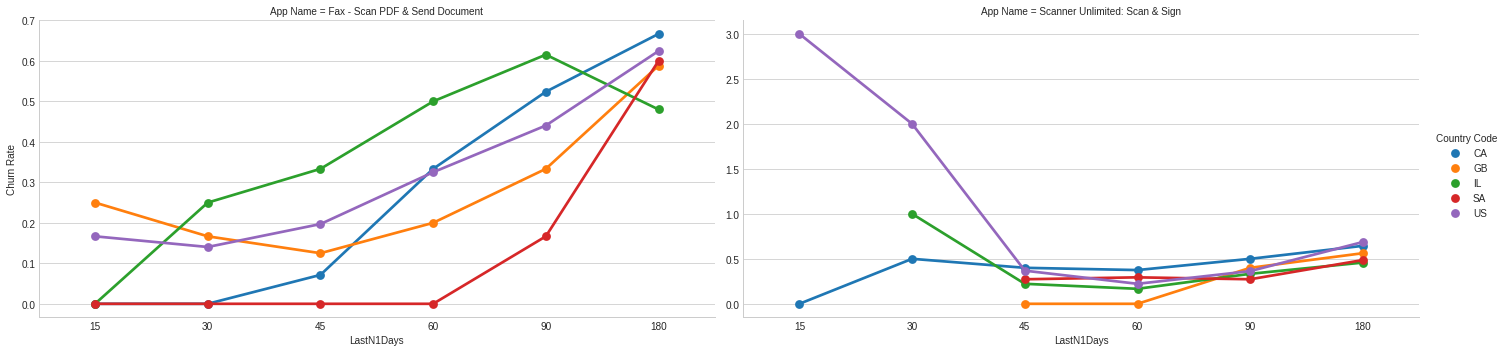

In [ ]:
scanner_plot = scanner_final.reset_index()
sns.factorplot(x='LastN1Days', y='Churn Rate', hue='Country Code', 
               col='App Name', data=scanner_plot, col_wrap=2,
              sharey=False, size=5, aspect=2)

### INSPECTING PACKAGES/COUNTRIES

In [ ]:
churn1_cohort = pd.read_csv('/content/Churn1_Cohort.csv')
churn1_for_merge = churn1_cohort[['Original Start Date', 'App Apple ID', 'Country Code', 'Package ID', 'Intro Type', 'Type', 'Period', 'Value']]


In [ ]:
churn1_merged = pd.merge(churn1_for_merge, churn1_subs, left_on= ['Original Start Date',
                                                                  'App Apple ID',
                                                                  'Country Code',
                                                                  'Package ID'], right_on = ['Original Start Date',
                                                                                             'App Apple ID',
                                                                                             'Country Code',
                                                                                             'Package ID'],)
churn1_merged.head()

,Original Start Date,App Apple ID,Country Code,Package ID,Intro Type,Type,Period,Value,Intro Duration,newSubs,Engagement,Total Churn,Cancel from Introductory,Intro,Original Start Date With Intro,LastNDays
0,2019-12-01,1435773823,KR,1487914502,I,C,0,5,1 Month,0,7,2,5,30,2019-12-31,777
1,2019-12-01,1435773823,KR,1487914502,I,C,-1,1,1 Month,0,7,2,5,30,2019-12-31,777
2,2019-12-01,1435773823,KR,1487914502,I,R,0,1,1 Month,0,7,2,5,30,2019-12-31,777
3,2019-12-29,1435773823,KR,1446241754,T,C,0,11,3 Days,1,13,1,11,3,2020-01-01,749
4,2019-12-29,1435773823,KR,1446241754,T,R,1,1,3 Days,1,13,1,11,3,2020-01-01,749


In [ ]:
churn1_merged = churn1_merged[['Original Start Date',
                               'App Apple ID',
                               'Country Code',
                               'Package ID',
                               'Intro Type',
                               'Type', 
                               'Period',
                               'Value',
                               'Intro Duration',
                               'newSubs',
                               'Cancel from Introductory',
                               'Total Churn',
                               'LastNDays']]

In [ ]:
package_list = key_set.drop_duplicates(['Subscription Apple ID'])
package_list=package_list[['Subscription Apple ID', 'Subscription Name', 'Standard Subscription Duration']]
app_name_list = key_set.drop_duplicates(['App Apple ID'])
app_name_list = app_name_list[['App Apple ID', 'App Name']]


In [ ]:
churn1_merged = pd.merge(churn1_merged, app_name_list, how = 'left' ,on= 'App Apple ID')
churn1_merged.head()

,Original Start Date,App Apple ID,Country Code,Package ID,Intro Type,Type,Period,Value,Intro Duration,newSubs,Cancel from Introductory,Total Churn,LastNDays,App Name
0,2019-12-01,1435773823,KR,1487914502,I,C,0,5,1 Month,0,5,2,777,Call Recorder - Save & Listen
1,2019-12-01,1435773823,KR,1487914502,I,C,-1,1,1 Month,0,5,2,777,Call Recorder - Save & Listen
2,2019-12-01,1435773823,KR,1487914502,I,R,0,1,1 Month,0,5,2,777,Call Recorder - Save & Listen
3,2019-12-29,1435773823,KR,1446241754,T,C,0,11,3 Days,1,11,1,749,Call Recorder - Save & Listen
4,2019-12-29,1435773823,KR,1446241754,T,R,1,1,3 Days,1,11,1,749,Call Recorder - Save & Listen


# **CHURN PATTERNS**

In [ ]:
key_set.head()


,Original Start Date,App Name,App Apple ID,Country,Subscription Name,Subscription Apple ID,Standard Subscription Duration,Intro Type,Subscription Offer Duration,Subscription Offer Type,Customer Price,Customer Currency,Developer Proceeds,Proceeds Currency,trialPrice,trialCurrency,trialProceed,trialProceedCurrency
0,2021-10-16,Call Recorder - Save & Listen,1.435774e+09,AR,Call Recorder Month Trial V2,1.446242e+09,1 Month,S,Non Duration,NaN,12.99,USD,9.10,USD,0.0,NaN,0.0,NaN
1,2021-10-15,Call Recorder - Save & Listen,1.435774e+09,AU,Call Recorder Month,1.435776e+09,1 Month,S,Non Duration,NaN,32.99,AUD,20.99,AUD,0.0,NaN,0.0,NaN
2,2021-10-15,Interview & Meeting Recorder,1.505287e+09,AU,Monthly one person v2,1.535635e+09,1 Month,S,Non Duration,NaN,48.99,AUD,31.18,AUD,0.0,NaN,0.0,NaN
3,2021-10-17,Scanner Unlimited: Scan & Sign,1.439290e+09,AU,Scanner Pro Year Trial,1.439370e+09,1 Year,S,Non Duration,NaN,129.99,AUD,82.72,AUD,0.0,NaN,0.0,NaN
4,2021-10-17,Fax - Scan PDF & Send Document,1.450602e+09,AU,Fax Month v2,1.548625e+09,1 Month,S,Non Duration,NaN,42.99,AUD,27.36,AUD,0.0,NaN,0.0,NaN


In [ ]:
package_list1 = key_set.drop_duplicates(['Subscription Apple ID','Country'])
package_list1=package_list1[['Subscription Apple ID', 'Subscription Name', 'Country', 'Standard Subscription Duration', 'Customer Price', 'Customer Currency']]

In [ ]:
churn2 = churn2.replace(' ', 0)
churn2['Period']= churn2['Period'].astype(int)

In [ ]:
churn21 = pd.merge(app_name_list, churn2, left_on= 'App Apple ID', right_on= 'AppID', how='left')
churn22 = pd.merge(churn21, package_list1, left_on = ['Package ID', 'Country Code'], right_on = ['Subscription Apple ID', 'Country'], how='left')

In [ ]:
pattern_mask = churn22['Country Code'].isin(scanner_countries)
churn22 = churn22[pattern_mask]

In [ ]:
namelist11= namelist['App Name']
app_mask = churn22['App Name'].isin(namelist11)
churn22 = churn22[app_mask]

In [ ]:
churn22['Period'] = churn22['Period'].astype(int)
churn22['Churn Date'] = pd.to_datetime(churn22['Original Start Date']) +  pd.to_timedelta(churn22['Period'], 'D')
churn22['Churn Month'] = churn22['Churn Date'].dt.to_period('M')

In [ ]:
churn22 = churn22[churn22['Original Start Date']>= (pd.to_datetime('16.01.2022') - pd.to_timedelta(180, 'D'))]
op = churn22.groupby(['Country Code', 'Subscription Name', 'Churn Month'])['Value'].sum()
op

Country Code  Subscription Name                     Churn Month
CA            Call Recorder (x) Month Trial $19.99  2021-07         1.0
                                                    2021-08         1.0
                                                    2021-09         1.0
                                                    2021-10         2.0
              Call Recorder (x) Year Trial V2       2021-07         4.0
                                                                   ... 
US            Yearly v4                             2021-09         6.0
                                                    2021-10        10.0
                                                    2021-11         7.0
                                                    2021-12         2.0
                                                    2022-01         1.0
Name: Value, Length: 393, dtype: float64

## **CHURN PATTERN COMMENTS**

* We cay say that yearly v4 package is not working well in Israel.
* Call Recorder weekly package in Great Britain has an increasing trend of churn values.


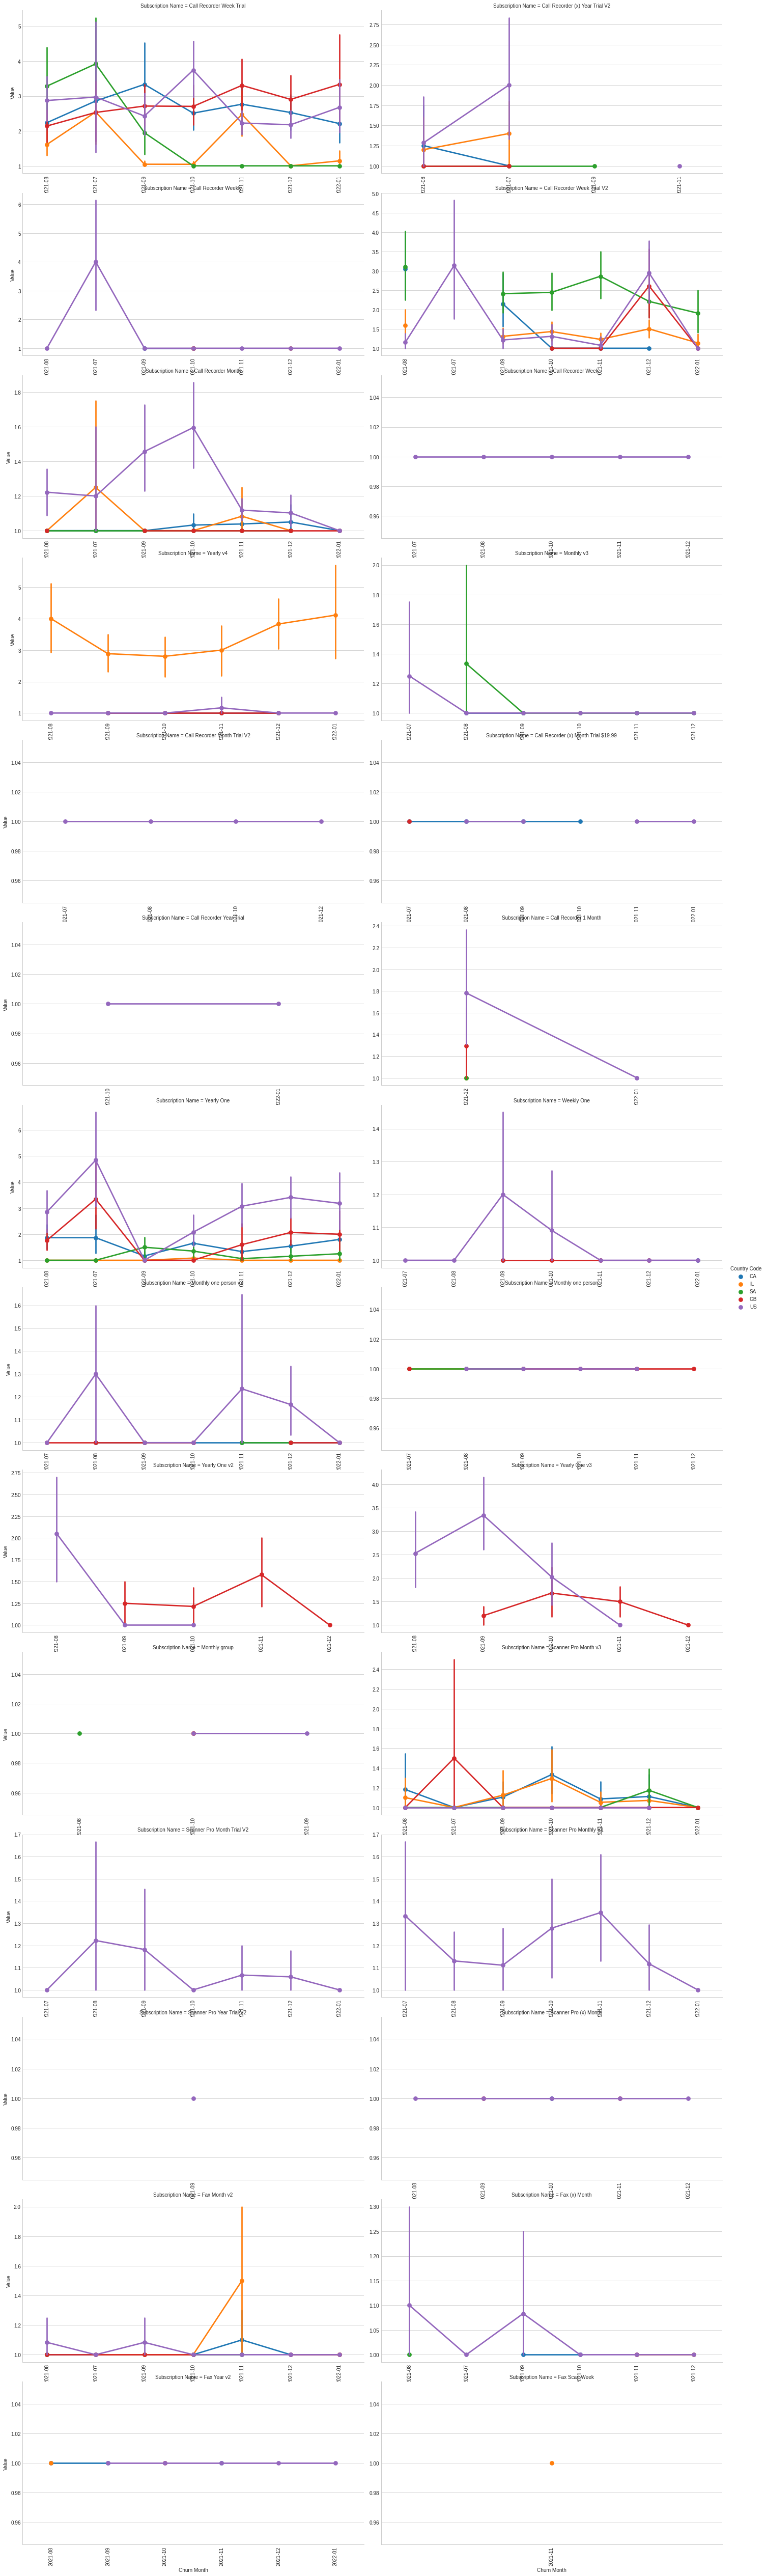

In [ ]:
sns.catplot(x='Churn Month', y='Value', hue='Country Code', 
               col='Subscription Name', data=churn22, col_wrap=2,
              sharey=False, sharex=False,kind='point', size=5, aspect=2).set_xticklabels(rotation=90)

#### We create a new metric to understand the churn patterns. We create a density column which shows us the center of churns as period.

In [ ]:
churn3_scanner_plot = churn1_scanner_plot
churn3_scanner_plot['Churn Sum'] = churn3_scanner_plot.groupby(['Subscription Name', 'Country Code'])['Total Churn'].transform(np.sum)
churn4_scanner_plot = churn3_scanner_plot[churn3_scanner_plot['Period']<20]

In [ ]:
churn3_scanner_plot['Churn Rate not Cum'] = churn3_scanner_plot['Total Churn']/ churn3_scanner_plot['newSubs']
churn4_scanner_plot = churn3_scanner_plot[churn3_scanner_plot['Period']<20]


## **CHURN RATES / PERIODS FOR PACKAGES IN TARGET COUNTRIES**

When we analyze the figure below, we can say that:

*   **Fax (x) Month Package in Canada has a greater churn rate in the first period of payment.**  
*   **Scanner Pro Month V3 package in US doesn't seem to work well as other target countries.**
*   **Scanner Pro Trial V2 package in Canada has greater churn rate in first and second period.**












### **PERIOD CENTER OF CHURNS AS A NEW METRIC(BASED ON PAYMENT PERIODS)**

In [ ]:
churn3_scanner_plot['ChurnMoment']= churn3_scanner_plot['Period'] * churn3_scanner_plot['Total Churn']

In [ ]:
churn3_scanner_plot['Churn Moment Sum'] = churn3_scanner_plot.groupby(['Subscription Name', 'Country Code'])['ChurnMoment'].transform(np.sum)


In [ ]:
churn3_scanner_plot['Center'] = churn3_scanner_plot['Churn Moment Sum'] / churn3_scanner_plot['Churn Sum']
centerchurn = churn3_scanner_plot.groupby(['Subscription Name','Country Code'])['Center'].mean()
centerchurn = centerchurn.reset_index()
centerchurn



,Subscription Name,Country Code,Center
0,Fax (x) Month,CA,1.526814
1,Fax (x) Month,GB,1.539216
2,Fax (x) Month,IL,2.104167
3,Fax (x) Month,SA,1.772152
4,Fax (x) Month,US,2.246790
...,...,...,...
59,Scanner Pro Year Trial V2,CA,1.262295
60,Scanner Pro Year Trial V2,GB,1.076923
61,Scanner Pro Year Trial V2,IL,1.140940
62,Scanner Pro Year Trial V2,SA,1.166667


With this metric we can understand the center of total churns which shows us what period does customer tend to come out. When we analyze the figure below:


*   **Fax Week V2 Package churn period centers in Great Britain and South Africa are remarkably lower than the other countries. Some action may be neeeded for this package in those countries.** 
*   **Scanner Pro Month Trial V2 in Canada has greatest center value, Great Britain, Israel and United States values are way lower. Canada price for that package may be the factor.**  



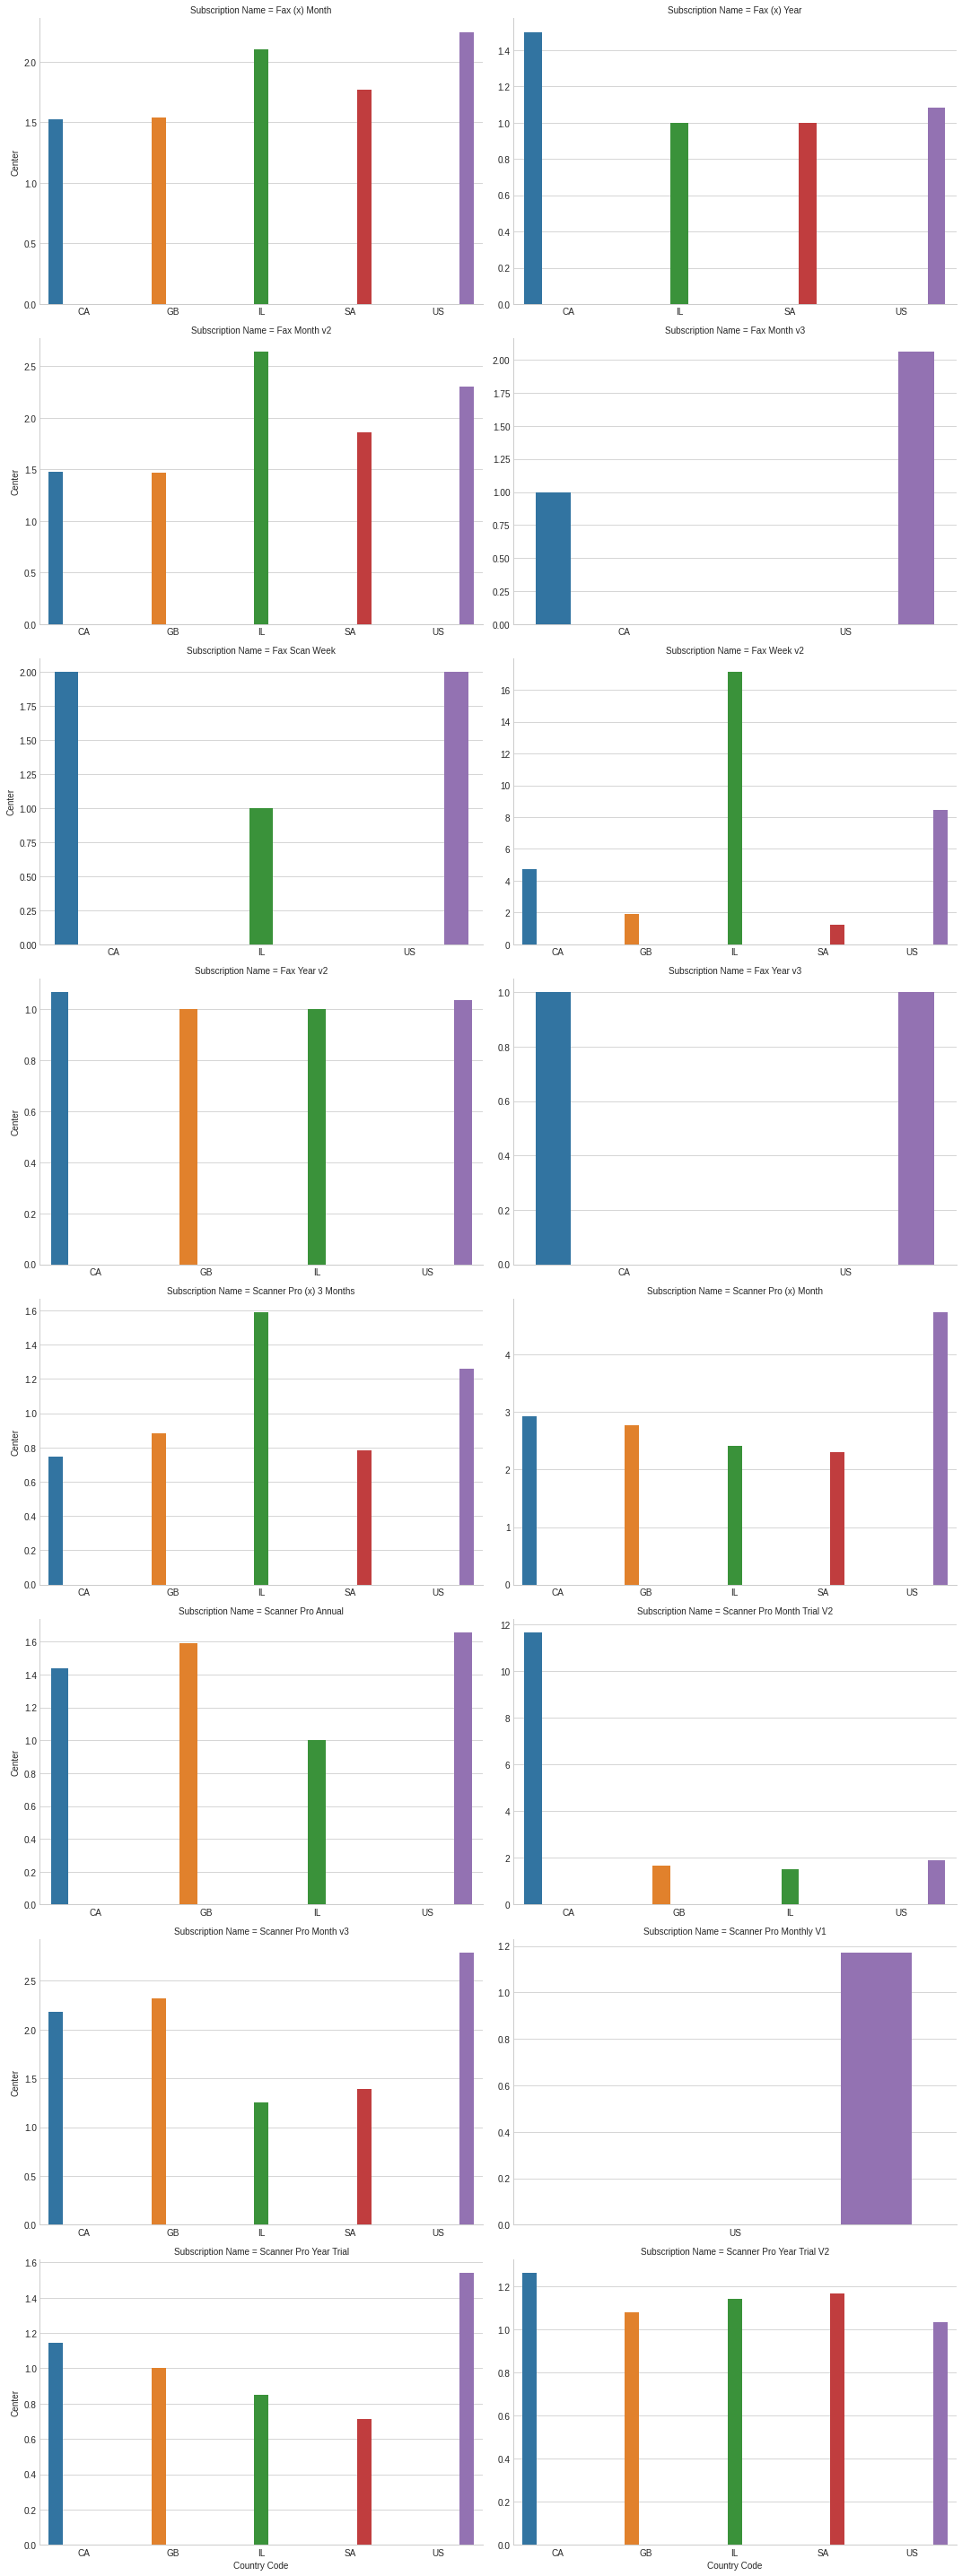

In [ ]:
sns.catplot(
    data=centerchurn, x="Country Code", y="Center", col="Subscription Name",
    hue="Country Code", kind="bar" ,col_wrap= 2, aspect= 1.5, legend_out=False,
    sharex = False, sharey=False)

# **RETENTION**

In [ ]:
retention1= pd.merge(churn2, package_list, left_on= 'Package ID', right_on = 'Subscription Apple ID')
retention1 = retention1.rename(columns={'AppID': 'App Apple ID'})
retention1.dtypes
retention1

,Original Start Date,App Apple ID,Country Code,Package ID,Type,Period,Value,Subscription Apple ID,Subscription Name,Standard Subscription Duration
0,2021-08-04,1435773823,AR,1435787587,C,0,1,1.435788e+09,Call Recorder Week Trial,7 Days
1,2021-08-04,1435773823,AR,1435787587,C,1,1,1.435788e+09,Call Recorder Week Trial,7 Days
2,2021-08-05,1435773823,AR,1435787587,C,0,2,1.435788e+09,Call Recorder Week Trial,7 Days
3,2021-08-04,1435773823,AU,1435787587,C,0,2,1.435788e+09,Call Recorder Week Trial,7 Days
4,2021-07-07,1435773823,AU,1435787587,C,30,1,1.435788e+09,Call Recorder Week Trial,7 Days
...,...,...,...,...,...,...,...,...,...,...
143545,2021-12-06,1575519473,US,1590036680,R,28,1,1.590037e+09,Monthly Pro Subscription New,1 Month
143546,2021-12-04,1575519473,DE,1590036680,C,0,1,1.590037e+09,Monthly Pro Subscription New,1 Month
143547,2021-12-06,1575519473,US,1590036680,C,10,1,1.590037e+09,Monthly Pro Subscription New,1 Month
143548,2021-12-06,1575519473,US,1590036680,C,0,1,1.590037e+09,Monthly Pro Subscription New,1 Month


In [ ]:
retention1= pd.merge(retention1, namelist, on='App Apple ID', how='left')
churn1_subs1.head()

,Original Start Date,App Apple ID,Country Code,Package ID,Intro Duration,newSubs,Engagement,Total Churn,Cancel from Introductory,Intro,Original Start Date With Intro,LastNDays,App Name
0,2019-10-31,1439290223,KZ,1447548278,3 Days,0,0,0,0,3,2019-11-03,808,Scanner Unlimited: Scan & Sign
1,2020-01-01,1439290223,KZ,1447548278,3 Days,0,1,0,1,3,2020-01-04,746,Scanner Unlimited: Scan & Sign
2,2019-12-28,1435773823,KZ,1446241754,3 Days,1,2,1,1,3,2019-12-31,750,Call Recorder - Save & Listen
3,2019-10-30,1435773823,KZ,1446242014,3 Days,0,0,0,0,3,2019-11-02,809,Call Recorder - Save & Listen
4,2019-10-31,1435773823,KZ,1446242014,3 Days,0,0,1,0,3,2019-11-03,808,Call Recorder - Save & Listen


In [ ]:
countries_mask = retention1['Country Code'].isin(recorder_countries)
retention1 = retention1[countries_mask]
retention1['Country Code'].unique()

array(['AU', 'CA', 'IN', 'IL', 'JP', 'KR', 'SA', 'TR', 'GB', 'US'],
      dtype=object)

In [ ]:
churn1_subs1['Period']='0'
churn1_subs1['Period']= churn1_subs1['Period'].astype(int)
retention1.replace(' ', np.nan, inplace=True)
retention1['Period'] = retention1['Period'].fillna(0)
retention1['Period'] = retention1['Period'].astype(int)
churn1_subs1['Original Start Date'] = pd.to_datetime(churn1_subs1['Original Start Date'])

In [ ]:
retention = pd.merge(retention1, churn1_subs1, on=['Original Start Date', 'App Apple ID', 'Package ID', 'Country Code', 'Period'], how= 'left')

In [ ]:
retention=retention[['Original Start Date', 'App Apple ID','App Name_x', 'Country Code', 'Package ID', 'Subscription Name','Period','Value','newSubs', 'Standard Subscription Duration', 'Intro']]
retention['newSubs']= retention['newSubs'].fillna(0)
retention = retention[(pd.to_datetime(retention['Original Start Date'])>= pd.to_datetime('01.01.2021'))]
retention = retention.sort_values(by=['Country Code','Package ID','App Apple ID','Period'])
retention['Intro']= retention['Intro'].fillna(method='bfill')

In [ ]:
retention_grouped = retention.groupby(['Country Code','Subscription Name'])['newSubs'].sum()
retention_grouped = retention_grouped.reset_index().sort_values(by='newSubs')
retention_grouped

,Country Code,Subscription Name,newSubs
0,AU,"1 week | 7,99 | 3 | start* - 1520170002",0.0
185,IN,Scanner Pro (x) 3 Months,0.0
188,IN,Vpn Trial Year,0.0
190,IN,Weekly One,0.0
191,IN,Yearly,0.0
...,...,...,...
204,JP,Call Recorder Week Trial V2,1699.0
231,JP,Yearly v4,1916.0
380,US,Yearly One,2266.0
197,JP,Call Recorder (x) Month Trial $19.99,3375.0


In [ ]:
retention_grouped = retention_grouped.sort_values(by = ['Country Code','newSubs'],ascending=False).groupby(['Country Code']).head(2)
retention_grouped = retention_grouped.reset_index()[['Country Code', 'Subscription Name','newSubs']]
retention_grouped= retention_grouped[['Country Code', 'Subscription Name']]

In [ ]:
retention_final = pd.merge(retention_grouped, retention, on=['Country Code', 'Subscription Name'], how='left')
retention_final.head()

,Country Code,Subscription Name,Original Start Date,App Apple ID,App Name_x,Package ID,Period,Value,newSubs,Standard Subscription Duration,Intro
0,US,Call Recorder Week Trial,2021-08-04,1435773823,Call Recorder - Save & Listen,1435787587,0,1,23.0,7 Days,3.0
1,US,Call Recorder Week Trial,2021-07-31,1435773823,Call Recorder - Save & Listen,1435787587,0,1,9.0,7 Days,3.0
2,US,Call Recorder Week Trial,2021-08-05,1435773823,Call Recorder - Save & Listen,1435787587,0,21,15.0,7 Days,3.0
3,US,Call Recorder Week Trial,2021-06-05,1435773823,Call Recorder - Save & Listen,1435787587,0,1,2.0,7 Days,3.0
4,US,Call Recorder Week Trial,2021-06-06,1435773823,Call Recorder - Save & Listen,1435787587,0,1,1.0,7 Days,3.0


In [ ]:

retention_final['Original Start Date']= pd.to_datetime(retention_final['Original Start Date'])
retention_final = retention_final[(retention_final['Original Start Date'] > pd.to_datetime("1 January 2021")) & (retention_final['Original Start Date'] < pd.to_datetime("1 January 2022"))]
retention_final['Churn Date']= pd.to_datetime(retention_final['Original Start Date']) +  pd.to_timedelta(retention_final['Period'], unit='d')



In [ ]:
retention_final['Churn Month'] = (( retention_final['Churn Date']-retention_final['Original Start Date'])/np.timedelta64(1,'M'))
retention_final['Churn Month'] = retention_final['Churn Month'].astype(int)
retention_final[retention_final['Churn Date'] <= (pd.to_datetime(retention_final['Original Start Date']) +  pd.to_timedelta(retention_final['Intro'], unit='d'))]
## Substract canceled churn while intro duration
retention_final['Value'] = np.where((retention_final['Churn Date'] <= (retention_final['Original Start Date'] +  pd.to_timedelta(retention_final['Intro'], unit='d'))) &  (retention_final['Intro']!=0), 0, retention_final['Value'])
retention_final['Month'] = pd.DatetimeIndex(retention_final['Original Start Date']).month
retention_final['Churn Month'] = ((retention_final['Churn Date'] - retention_final['Original Start Date'])/np.timedelta64(1, 'M'))
retention_final['Churn Month'] = retention_final['Churn Month'].astype(int)

In [ ]:
retention_final11= retention_final[retention_final['Churn Date']< pd.to_datetime("1 January 2022")]
retention_final11

,Country Code,Subscription Name,Original Start Date,App Apple ID,App Name_x,Package ID,Period,Value,newSubs,Standard Subscription Duration,Intro,Churn Date,Churn Month,Month
0,US,Call Recorder Week Trial,2021-08-04,1435773823,Call Recorder - Save & Listen,1435787587,0,0,23.0,7 Days,3.0,2021-08-04,0,8
1,US,Call Recorder Week Trial,2021-07-31,1435773823,Call Recorder - Save & Listen,1435787587,0,0,9.0,7 Days,3.0,2021-07-31,0,7
2,US,Call Recorder Week Trial,2021-08-05,1435773823,Call Recorder - Save & Listen,1435787587,0,0,15.0,7 Days,3.0,2021-08-05,0,8
3,US,Call Recorder Week Trial,2021-06-05,1435773823,Call Recorder - Save & Listen,1435787587,0,0,2.0,7 Days,3.0,2021-06-05,0,6
4,US,Call Recorder Week Trial,2021-06-06,1435773823,Call Recorder - Save & Listen,1435787587,0,0,1.0,7 Days,3.0,2021-06-06,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16032,AU,Yearly One,2021-08-04,1505286803,Interview & Meeting Recorder,1535633619,56,1,0.0,1 Year,0.0,2021-09-29,1,8
16033,AU,Yearly One,2021-08-11,1505286803,Interview & Meeting Recorder,1535633619,61,1,0.0,1 Year,0.0,2021-10-11,2,8
16034,AU,Yearly One,2021-07-29,1505286803,Interview & Meeting Recorder,1535633619,64,1,0.0,1 Year,0.0,2021-10-01,2,7
16035,AU,Yearly One,2021-07-11,1505286803,Interview & Meeting Recorder,1535633619,85,1,0.0,1 Year,0.0,2021-10-04,2,7


### **RETENTION RATE/PAYMENT PERIODS PIVOT TABLE FOR TARGET COUNTRIES**

In [ ]:
p1 = retention_final11.groupby(['Country Code', 'Subscription Name', 'Month', 'Churn Month'])['Value'].sum()
p2 = retention_final11.groupby(['Country Code', 'Subscription Name', 'Month', 'Churn Month'])['newSubs'].sum()
p = pd.concat([p1,p2], axis=1)
p
          

Value  newSubs
Country Code Subscription Name        Month Churn Month                
AU           Call Recorder Week Trial 4     0                1      1.0
                                            2                1      0.0
                                      5     0                9     22.0
                                            1                4      0.0
                                            5                2      0.0
...                                                        ...      ...
US           Yearly One               10    0               20     26.0
                                            1                1      0.0
                                      11    0               49    101.0
                                            1                3      0.0
                                      12    0              104    277.0

[642 rows x 2 columns]

In [ ]:
p['Churn Cumsum'] = p.groupby(['Country Code', 'Subscription Name', 'Month'])['Value'].cumsum()


In [ ]:
retention_final_groupy = p.groupby(['Country Code', 'Subscription Name','Month'])['newSubs']
p['newSum'] = retention_final_groupy.transform('sum')
p['Living Ones'] = p['newSum']-p['Churn Cumsum']
p['Retention Rate']= p['Living Ones']/p['newSum']
fff = p.reset_index()
fff.pivot_table(index= ['Country Code', 'Subscription Name', 'Month'], columns= 'Churn Month', aggfunc={'Retention Rate':sum}).sort_values(by=['Month'], ascending= True)


Retention Rate  ...    
Churn Month                                                         0   ...  11
Country Code Subscription Name                    Month                 ...    
GB           Yearly One                           1           0.500000  ... NaN
TR           Call Recorder (x) Month Trial $19.99 1           0.245989  ... NaN
KR           Call Recorder (x) Month Trial $19.99 1           0.240000  ... NaN
JP           Yearly v4                            1                NaN  ... NaN
CA           Call Recorder Week Trial             1               -inf  ... NaN
...                                                                ...  ...  ..
AU           Yearly One                           12          0.000000  ... NaN
SA           Call Recorder Week Trial             12          1.000000  ... NaN
AU           Call Recorder Week Trial             12          0.756757  ... NaN
IN           Call Recorder Week Trial             12          0.876712  ... NaN
US           Yearly One                           12          0.624549  ... NaN

[189 rows x 12 columns]

### **FORECASTING RETENTION RATES**

We will use fbprophet package to forecast retention values.

In [ ]:
retention_groupedd = retention.groupby(['Country Code','App Name_x'])['newSubs'].sum()
retention_groupedd = retention_groupedd.reset_index().sort_values(by='newSubs')

In [ ]:
retention_groupedd = retention_groupedd.sort_values(by = ['Country Code','newSubs'],ascending=False).groupby(['Country Code']).head(2)
retention_groupedd = retention_groupedd.reset_index()[['Country Code', 'App Name_x','newSubs']]
retention_groupedd = retention_groupedd[['Country Code', 'App Name_x']]
retention_groupedd

,Country Code,App Name_x
0,US,Call Recorder - Save & Listen
1,US,Interview & Meeting Recorder
2,TR,Call Recorder - Save & Listen
3,TR,Interview & Meeting Recorder
4,SA,Call Recorder - Save & Listen
5,SA,Scanner Unlimited: Scan & Sign
6,KR,Call Recorder - Save & Listen
7,KR,Fax - Scan PDF & Send Document
8,JP,Call Recorder - Save & Listen
9,JP,Interview & Meeting Recorder


In [ ]:
retention_final2 = pd.merge(retention_groupedd, retention, on=['Country Code','App Name_x'], how='left')
retention_final2.iloc[0,:]
retention_final2 = retention_final2[['Original Start Date',
                                   'App Apple ID',
                                   'App Name_x',
                                   'Package ID',
                                   'Subscription Name',
                                   'Country Code',
                                   'Period',
                                   'Standard Subscription Duration',
                                   'Intro',
                                   'Value',
                                   'newSubs']]
retention_final2

,Original Start Date,App Apple ID,App Name_x,Package ID,Subscription Name,Country Code,Period,Standard Subscription Duration,Intro,Value,newSubs
0,2021-01-05,1435773823,Call Recorder - Save & Listen,1435775013,Call Recorder Year Trial,US,0,1 Year,3.0,1,0.0
1,2021-02-11,1435773823,Call Recorder - Save & Listen,1435775013,Call Recorder Year Trial,US,0,1 Year,3.0,1,0.0
2,2021-03-03,1435773823,Call Recorder - Save & Listen,1435775013,Call Recorder Year Trial,US,0,1 Year,3.0,1,0.0
3,2021-03-05,1435773823,Call Recorder - Save & Listen,1435775013,Call Recorder Year Trial,US,0,1 Year,3.0,2,0.0
4,2021-03-06,1435773823,Call Recorder - Save & Listen,1435775013,Call Recorder Year Trial,US,0,1 Year,3.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
29276,2021-03-03,1505286803,Interview & Meeting Recorder,1535635450,Monthly one person v2,AU,44,1 Month,0.0,1,0.0
29277,2021-05-24,1505286803,Interview & Meeting Recorder,1535635450,Monthly one person v2,AU,62,1 Month,0.0,1,0.0
29278,2021-08-14,1505286803,Interview & Meeting Recorder,1535635450,Monthly one person v2,AU,63,1 Month,0.0,1,0.0
29279,2021-07-16,1505286803,Interview & Meeting Recorder,1535635450,Monthly one person v2,AU,65,1 Month,0.0,1,0.0


In [ ]:
retention_final2['Churn Date']= pd.to_datetime(retention_final2['Original Start Date']) +  pd.to_timedelta(retention_final2['Period'], unit='d')
retention_final2['Month'] = retention_final2['Original Start Date'].dt.to_period('M')
retention_final2
## Substract canceled churn while intro duration
retention_final2['Value'] = np.where((retention_final2['Churn Date'] <= (retention_final2['Original Start Date'] +  pd.to_timedelta(retention_final2['Intro'], unit='d'))) &  (retention_final2['Intro']!=0), 0, retention_final2['Value'])

In [ ]:
retention_final2 = retention_final2[pd.to_datetime(retention_final2['Original Start Date']) > pd.to_datetime("18.10.2021")]



In [ ]:
retention_final2['Churn Month'] = retention_final2['Churn Date'].dt.to_period('M')
retention_final2



,Original Start Date,App Apple ID,App Name_x,Package ID,Subscription Name,Country Code,Period,Standard Subscription Duration,Intro,Value,newSubs,Churn Date,Month,Churn Month
54,2021-12-11,1435773823,Call Recorder - Save & Listen,1435775013,Call Recorder Year Trial,US,29,1 Year,0.0,1,0.0,2022-01-09,2021-12,2022-01
183,2021-10-19,1435773823,Call Recorder - Save & Listen,1435776429,Call Recorder Month,US,0,1 Month,0.0,2,7.0,2021-10-19,2021-10,2021-10
184,2021-10-20,1435773823,Call Recorder - Save & Listen,1435776429,Call Recorder Month,US,0,1 Month,0.0,6,23.0,2021-10-20,2021-10,2021-10
185,2021-10-21,1435773823,Call Recorder - Save & Listen,1435776429,Call Recorder Month,US,0,1 Month,0.0,3,16.0,2021-10-21,2021-10,2021-10
186,2021-10-22,1435773823,Call Recorder - Save & Listen,1435776429,Call Recorder Month,US,0,1 Month,0.0,1,10.0,2021-10-22,2021-10,2021-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29252,2021-12-04,1505286803,Interview & Meeting Recorder,1535635450,Monthly one person v2,AU,0,1 Month,0.0,1,1.0,2021-12-04,2021-12,2021-12
29260,2021-11-09,1505286803,Interview & Meeting Recorder,1535635450,Monthly one person v2,AU,2,1 Month,0.0,1,0.0,2021-11-11,2021-11,2021-11
29267,2021-11-20,1505286803,Interview & Meeting Recorder,1535635450,Monthly one person v2,AU,19,1 Month,0.0,1,0.0,2021-12-09,2021-11,2021-12
29272,2021-12-10,1505286803,Interview & Meeting Recorder,1535635450,Monthly one person v2,AU,32,1 Month,0.0,1,0.0,2022-01-11,2021-12,2022-01


In [ ]:
y1 = retention_final2.groupby(['Country Code', 'App Name_x', 'Month','Churn Month'])['Value'].sum()
y2 = retention_final2.groupby(['Country Code', 'App Name_x', 'Month','Churn Month'])['newSubs'].sum()
y = pd.concat([y1,y2], axis=1)
y['Churn Cumsum'] = y.groupby(['Country Code', 'App Name_x', 'Month'])['Value'].cumsum()
retention_final_groupy = y.groupby(['Country Code', 'App Name_x','Month'])['newSubs']
y['newSum'] = retention_final_groupy.transform('sum')
y['Living Ones'] = y['newSum']-y['Churn Cumsum']
y['Retention Rate']= y['Living Ones']/y['newSum']
y.reset_index()



,Country Code,App Name_x,Month,Churn Month,Value,newSubs,Churn Cumsum,newSum,Living Ones,Retention Rate
0,AU,Call Recorder - Save & Listen,2021-10,2021-10,4,39.0,4,39.0,35.0,0.897436
1,AU,Call Recorder - Save & Listen,2021-10,2021-11,10,0.0,14,39.0,25.0,0.641026
2,AU,Call Recorder - Save & Listen,2021-10,2021-12,5,0.0,19,39.0,20.0,0.512821
3,AU,Call Recorder - Save & Listen,2021-11,2021-11,18,66.0,18,66.0,48.0,0.727273
4,AU,Call Recorder - Save & Listen,2021-11,2021-12,23,0.0,41,66.0,25.0,0.378788
...,...,...,...,...,...,...,...,...,...,...
140,US,Interview & Meeting Recorder,2021-11,2021-11,54,118.0,54,118.0,64.0,0.542373
141,US,Interview & Meeting Recorder,2021-11,2021-12,23,0.0,77,118.0,41.0,0.347458
142,US,Interview & Meeting Recorder,2021-12,2021-12,138,311.0,138,311.0,173.0,0.556270
143,US,Interview & Meeting Recorder,2021-12,2022-01,24,0.0,162,311.0,149.0,0.479100


In [ ]:
ddd = y.reset_index()
ddd.pivot_table(index= ['Country Code', 'App Name_x', 'Month'], columns= 'Churn Month', aggfunc={'Retention Rate':sum})

Retention Rate  ...          
Churn Month                                               2021-10  ...   2022-01
Country Code App Name_x                    Month                   ...          
AU           Call Recorder - Save & Listen 2021-10       0.897436  ...       NaN
                                           2021-11            NaN  ...  0.348485
                                           2021-12            NaN  ...  0.396552
                                           2022-01            NaN  ...  0.947368
             Interview & Meeting Recorder  2021-10       0.500000  ...       NaN
...                                                           ...  ...       ...
US           Call Recorder - Save & Listen 2022-01            NaN  ...  0.897059
             Interview & Meeting Recorder  2021-10       0.227273  ...       NaN
                                           2021-11            NaN  ...       NaN
                                           2021-12            NaN  ...  0.479100
                                           2022-01            NaN  ...  0.688073

[74 rows x 4 columns]

In [ ]:
y['Total Churn']= y['Value']
y['Churn Cumsum'] = y.groupby(['Country Code', 'App Name_x', 'Month'])['Total Churn'].cumsum()
y=y.reset_index()
y['Retention Rate'] = (y['newSum'] - y['Churn Cumsum']) / y['newSum']
final_pivot2 = y.pivot_table(index = ['Country Code', 'App Name_x', 'Month', 'newSum', 'Churn Month'], aggfunc={'Retention Rate':'mean'}, fill_value=0 )
y = final_pivot2
y = y.reset_index()
y=y[y['Churn Month'] <= '2022-01']

In [ ]:
y.replace([np.inf, -np.inf], np.nan, inplace=True)

### **RETENTION FORECAST VISUAL**

In [ ]:
import os
from fbprophet import Prophet
import sys

In [ ]:
y['Churn Month'] = y['Churn Month'].astype(str) + '-' + '01'
y_country = y['Country Code'].unique()

You can change te country by typing country code to the second line in cell below

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 2.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disab

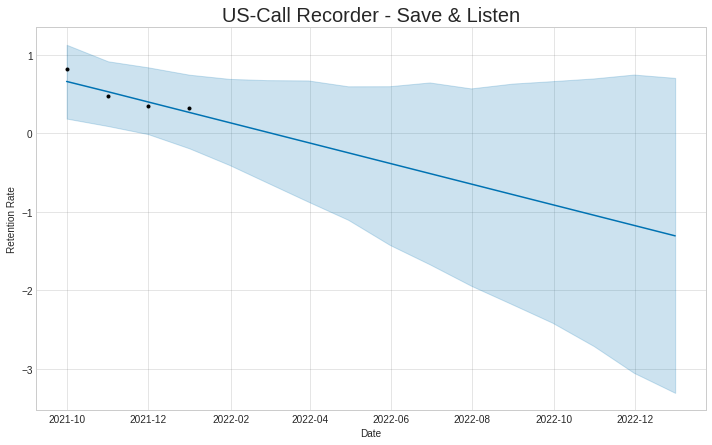

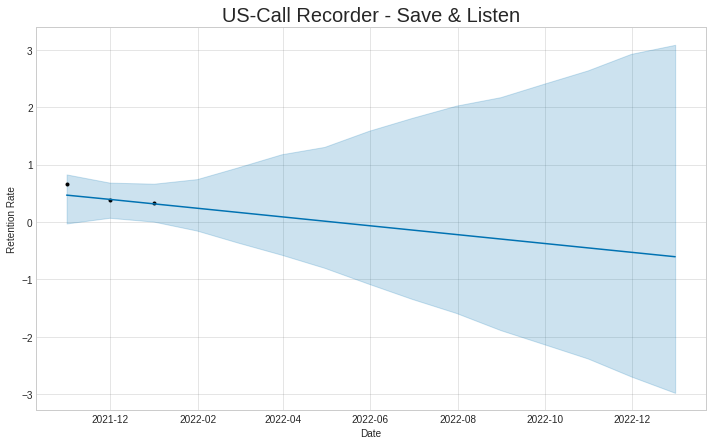

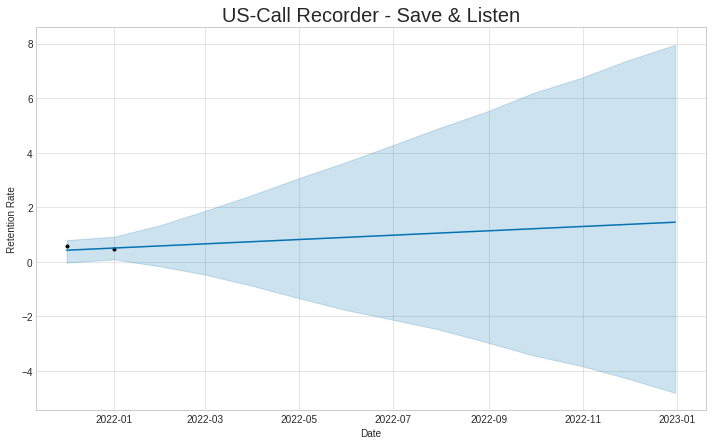

In [ ]:
k1 = y.rename(columns={'Churn Month':'ds', 'Retention Rate':'y'})
k1 = k1[k1['Country Code']=='US']
grouped_k1 = k1.groupby(['Country Code', 'App Name_x', 'Month'])
try:
  for g in grouped_k1.groups:
    group = grouped_k1.get_group(g)
    m = Prophet(seasonality_mode='additive', mcmc_samples=12)
    m.fit(group)
    future = m.make_future_dataframe(periods=12, freq='M')
    fcst = m.predict(future)
    fig = m.plot(fcst, xlabel='Date', ylabel='Retention Rate')
    ax = fig.gca()
    ax.set_title(group['Country Code'].iloc[0]+'-'+group['App Name_x'].iloc[0] , size=20)
except ValueError:
  pass